# Hyper Model Generation
- Author: Matthew Muller
- Date: 11/29/2022

Description: This notebook generates a hyperreactivity model for the given gene expression data. Data is normalized gene count expression data. Various models will be generated and compared to determine the best model for the given data using AUC and classification within a test set.


## General Housekeeping

In [8]:
######################################################################
#
#                      Library Imports
#
######################################################################
# Base Imports
import sys
import os
import numpy as np
import pandas as pd

# Plotting Imports
import matplotlib.pyplot as plt
import seaborn as sns
from adjustText import adjust_text

# ML Imports
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.decomposition import PCA, NMF, KernelPCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.metrics import roc_curve, confusion_matrix
from joblib import load
from sklearn.impute import SimpleImputer

# Stats Imports
from scipy.stats import kruskal, zscore

# Custom Imports
from MattTools import modeling, utils, plotting, stats


######################################################################
#
#                           Directory Setup
#
######################################################################
# # Set/Append Working directory
%cd /Users/muller/Ruggles Lab Dropbox/Matthew Muller/projects/platelet-activity
sys.path.append('/Documents/RugglesLab/platelet-activity')

experiment = "wb_hyper_geneset_modeling" # Add experiment name here

# Make output directory
outdir = 'output/' + experiment + '/'
if not os.path.exists(outdir):
    os.makedirs(outdir)

# Set seed for reproducibility
rng = 420
utils.set_random_seed(rng)
utils.hide_warnings('all')

/Users/muller/Ruggles Lab Dropbox/Matthew Muller/projects/platelet-activity
Setting random seed to 420 for reproducibility.


## Load in data

We are going to load in data from the following files refering to hypergeneset generation:
- output/wb_hyper_geneset_creation_norm

In [9]:
######################################################################
#
#                           Data Loading
#
######################################################################
# Load in data and labels
filter_val = "0.05"; norm = "cpm"
path = 'output/wb_hyper_geneset_creation_' + norm + '_norm/filt_' + filter_val + '/'
counts = pd.read_csv( path + 'hypercohort_counttable.csv', index_col=0).T

labels = pd.read_csv(path + 'hypercohort_labels.csv', index_col=0).to_numpy().ravel()

# Split data into train and test
X_train, X_test, y_train, y_test = train_test_split(counts, labels, test_size=0.2, stratify=labels)


# Standardize data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


# Print out shapes
print("X_train shape: ", X_train.shape)
print("X_test shape: ", X_test.shape)
print("y_train shape: ", y_train.shape)
print("y_test shape: ", y_test.shape)

# Print out class balance
print(f"Class balance: {np.round(np.unique(y_train, return_counts=True)[1] / len(y_train),3)}")

X_train shape:  (53, 88)
X_test shape:  (14, 88)
y_train shape:  (53,)
y_test shape:  (14,)
Class balance: [0.755 0.245]


## Model Generation

We are going to generate a model for each of the hypergenesets.

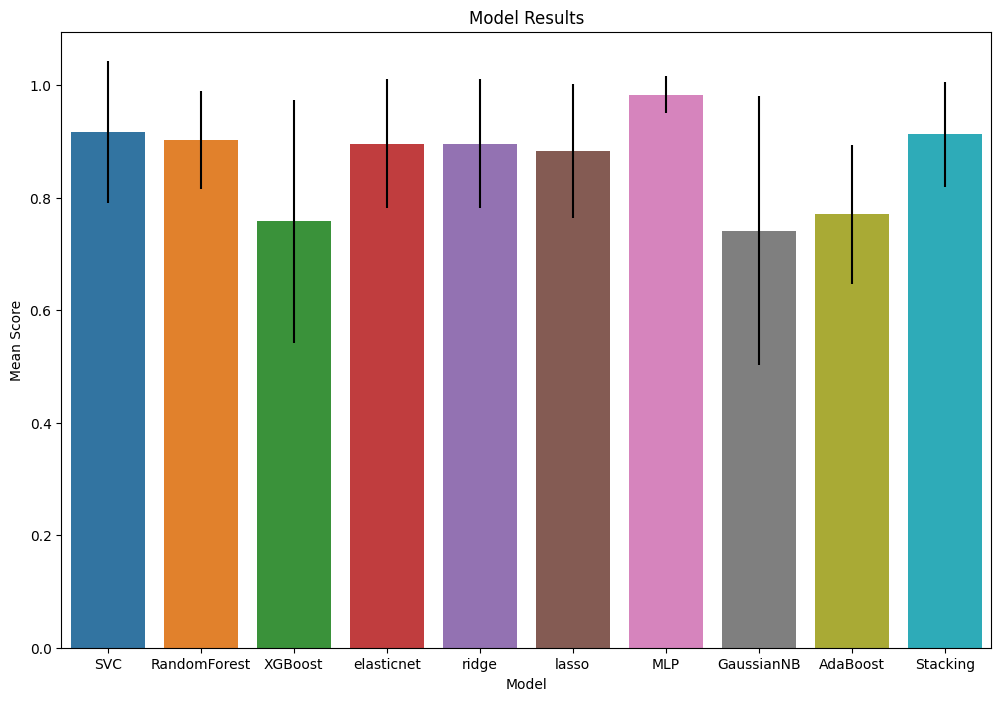

In [10]:
######################################################################
#
#                           Model Generation
#
######################################################################
# make a dict of model names and their corresponding models to test
# Models to try:
#  - SVC
#  - RandomForest
#  - XGBoost
#  - elasticnet
#  - ridge
#  - lasso
#  - MLP
#  - GaussianNB
#  - AdaBoost

# Import models
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import StackingClassifier

# Make positive class weight
pos_weight = np.sum(y_train == 0) / np.sum(y_train == 1)

# Make model dict
models = {
    'SVC': SVC(probability=True, class_weight='balanced'),
    'RandomForest': RandomForestClassifier(),
    'XGBoost': XGBClassifier(scale_pos_weight=pos_weight),
    'elasticnet': LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=0.75, class_weight='balanced'),
    'ridge': LogisticRegression(penalty='l2', solver='saga', class_weight='balanced'),
    'lasso': LogisticRegression(penalty='l1', solver='saga', class_weight='balanced'),
    'MLP': MLPClassifier(),
    'GaussianNB': GaussianNB(priors=[1/pos_weight, 1-1/pos_weight]),
    'AdaBoost': AdaBoostClassifier(),
    # Try stacking everything together??
    'Stacking': StackingClassifier(estimators=[
        ('SVC', SVC(probability=True, class_weight='balanced')),
        ('RandomForest', RandomForestClassifier()),
        ('XGBoost', XGBClassifier(scale_pos_weight=pos_weight)),
        ('elasticnet', LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=0.75, class_weight='balanced')),
        # ('ridge', LogisticRegression(penalty='l2', solver='saga', class_weight='balanced')),
        # ('lasso', LogisticRegression(penalty='l1', solver='saga', class_weight='balanced')),
        # ('MLP', MLPClassifier()),
        ('GaussianNB', GaussianNB(priors=[1/pos_weight, 1-1/pos_weight])),
        ('AdaBoost', AdaBoostClassifier())
        ], final_estimator=LogisticRegression(penalty='l2', solver='saga'))
        }

# Cross validate each model
model_results = modeling.cross_val_models(models, X_train, y_train, scoring='roc_auc')
# Plot results
plotting.plot_model_results(model_results)

# Feauture Selection

Feature selection will be applied using the models. Models will be evaluated post feature selection based on performance and feature reduction

Optimal number of features: 37


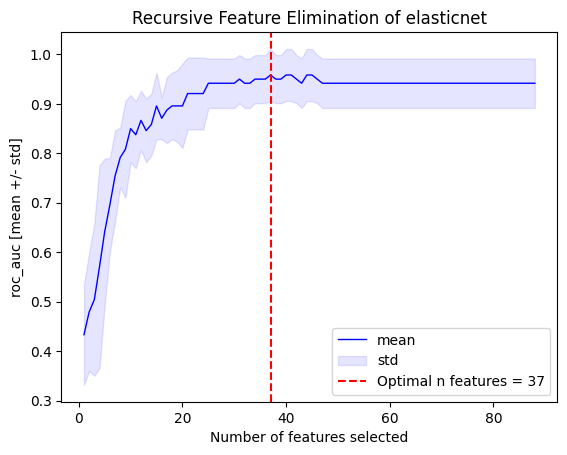

Optimal features (n=37):  Index(['ABCC6', 'ABO', 'AC009533.1', 'AC018644.1', 'AC023509.3', 'AC025442.2',
       'AC027020.2', 'AC027373.1', 'AC136475.2', 'AL513329.1', 'AL604028.2',
       'CCDC122', 'CDKN2A', 'CELA1', 'DBNDD2', 'DSP', 'DZIP1L', 'EDN1', 'ESR1',
       'F2RL1', 'FAM83F', 'FMN1', 'FNDC3B', 'GPRC5C', 'GRM2', 'HTRA3', 'KCNK5',
       'MYRF', 'NOMO3', 'OLFM1', 'PI4KAP1', 'PIPSL', 'PLPP7', 'PRRT4',
       'SORBS1', 'TMEM51', 'WNT6'],
      dtype='object')
counts shape:  (67, 37)
X_train shape:  (53, 37)
X_test shape:  (14, 37)


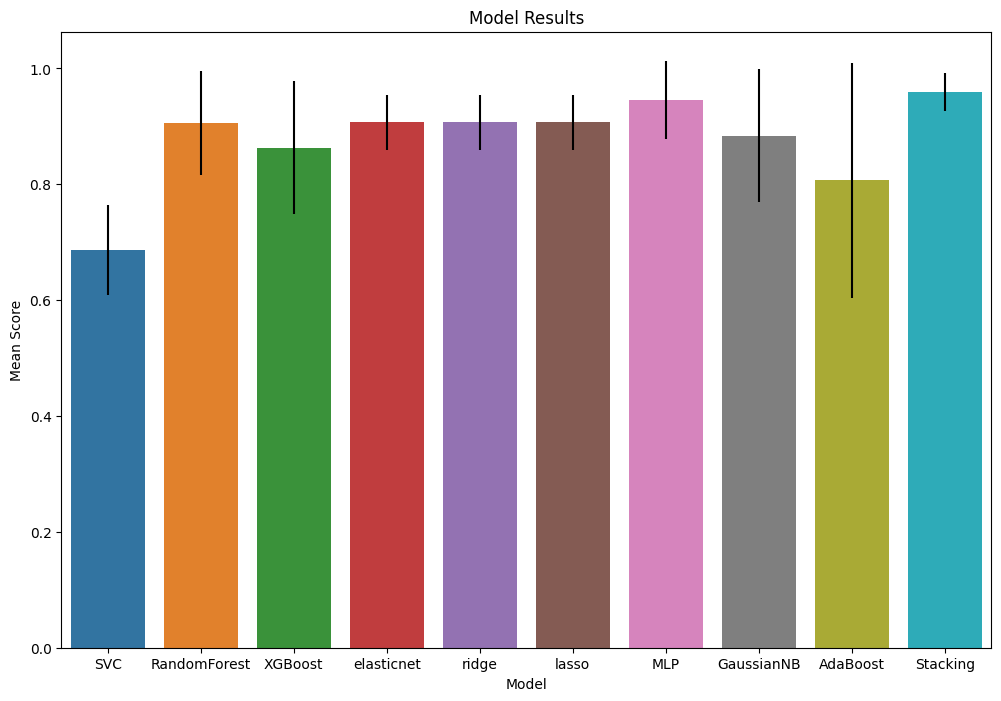

In [11]:
from sklearn.feature_selection import RFECV, SelectFromModel
from sklearn.model_selection import StratifiedKFold

# Create recursive feature elimination object
model = "elasticnet" # Model to use for feature selection
scoring = "roc_auc" # Scoring metric to use
min_features_to_select = 1  # Minimum number of features to consider
cv = StratifiedKFold(5)  # Cross-validation generator
# Create wrapper function to get feature importance
rfecv = RFECV(
    estimator=models[model],
    step=1,
    cv=cv,
    scoring="roc_auc",
    min_features_to_select=min_features_to_select,
)

# Fit recursive feature elimination object
rfecv.fit(X_train, y_train)
print(f"Optimal number of features: {rfecv.n_features_}")

# Plot number of features VS. cross-validation scores
n_scores = len(rfecv.cv_results_["mean_test_score"])
plt.figure()
plt.plot(
    range(min_features_to_select, n_scores + min_features_to_select),
    rfecv.cv_results_["mean_test_score"],
    color="b", label="mean", lw=1,
)
plt.fill_between(
    range(min_features_to_select, n_scores + min_features_to_select),
    rfecv.cv_results_["mean_test_score"] - rfecv.cv_results_["std_test_score"],
    rfecv.cv_results_["mean_test_score"] + rfecv.cv_results_["std_test_score"],
    alpha=0.1, color="b", label="std",
)
# add a line for the optimal number of features
plt.axvline(rfecv.n_features_, color="r", linestyle="--", label="Optimal n features = " + str(rfecv.n_features_))
plt.xlabel("Number of features selected")
plt.ylabel(f"{scoring} [mean +/- std]")
plt.title("Recursive Feature Elimination of " + model)
plt.legend(loc="lower right")
plt.savefig(outdir + "rfecv_" + model + ".png", dpi=300)
plt.show()

# Get the optimal features and transform the data
optimal_features = counts.columns[rfecv.support_]
counts = rfecv.transform(counts)
X_train = rfecv.transform(X_train)
X_test = rfecv.transform(X_test)

# Print out shapes
print(f"Optimal features (n={len(optimal_features)}): ", optimal_features)
print("counts shape: ", counts.shape)
print("X_train shape: ", X_train.shape)
print("X_test shape: ", X_test.shape)


# Cross validate models on new data
res = modeling.cross_val_models(models, counts, labels)
# Plot results using plot_model_results function
plotting.plot_model_results(res)

### Model Analytics

We will use the following metrics to determine the best model:
- AUC
- Classification within test set
- Cross Validation

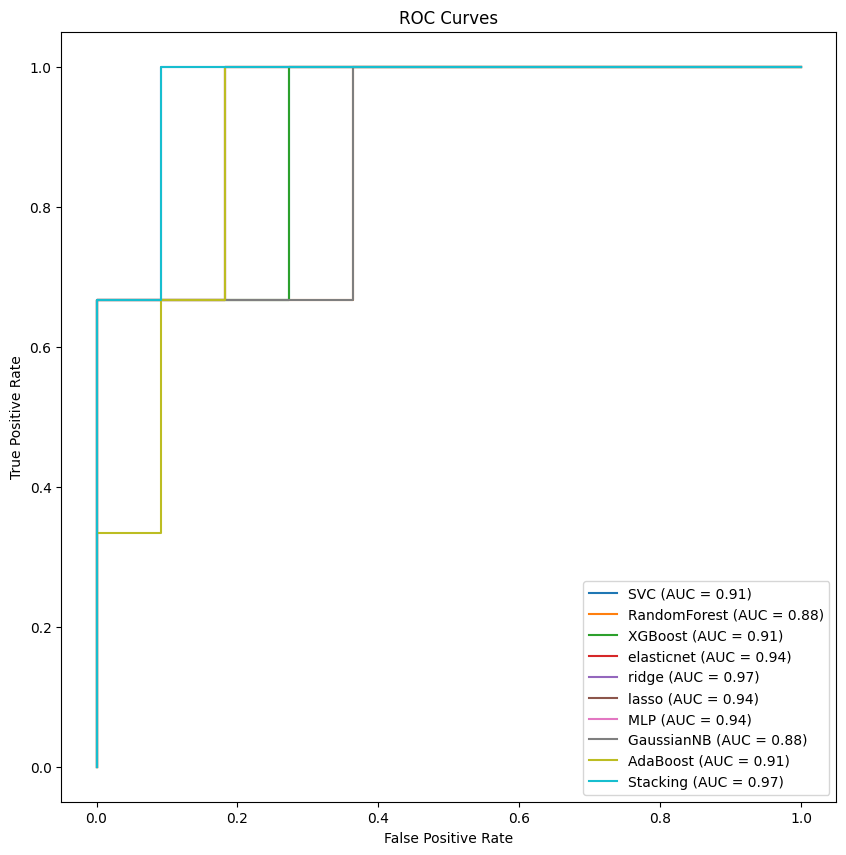

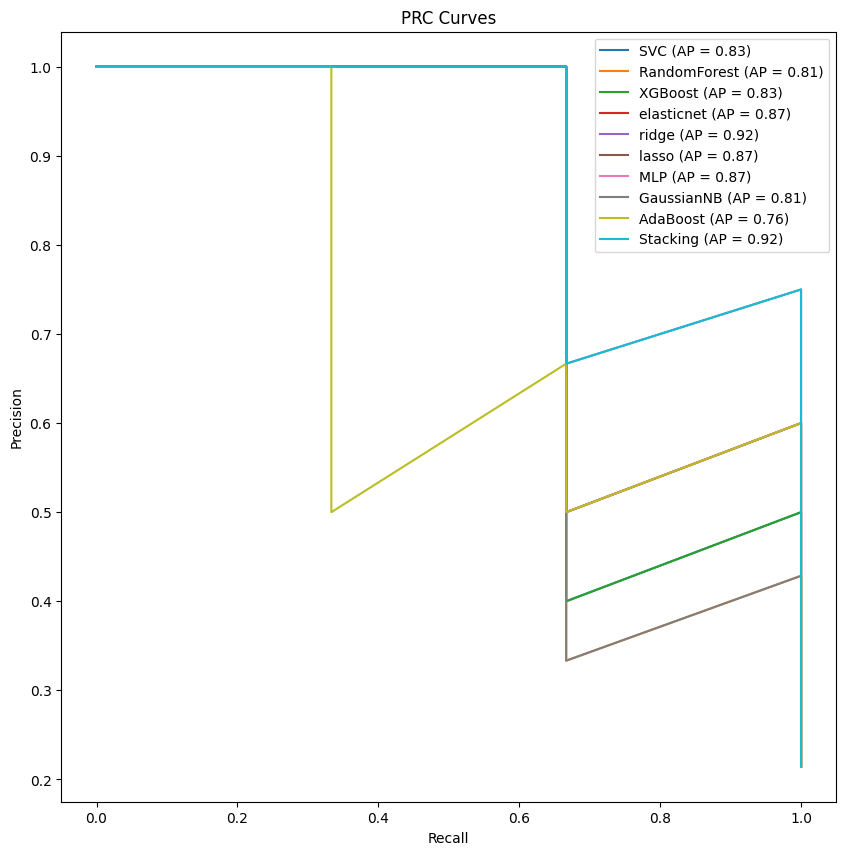

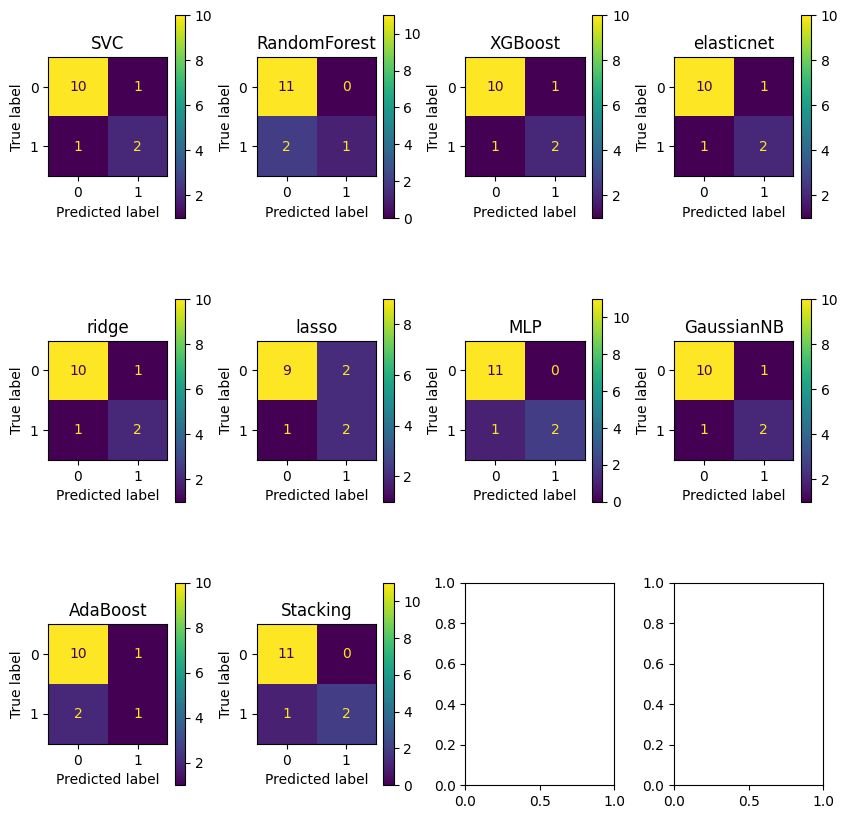

In [12]:
# Train models
models = modeling.train_models(models, X_train, y_train, random_state=rng)

# Plot the roc curves for each model
plotting.plot_roc_curves(models, X_test, y_test)

# Plot the prc curves for each model
plotting.plot_prc_curves(models, X_test, y_test)

# Plot the confusion matrices for each model
plotting.plot_confusion_matrices(models, X_test, y_test)

# Model Validation

The model will be validated within the following datasets:
- HARP WB Sequencing Data (using hyperreactivity)
- HARP WB Sequencing Data (using enrichment of MI-CAD)
- Ischemia Trial

harp_counts shape:  (10, 37)
harp_labels shape:  (10,)


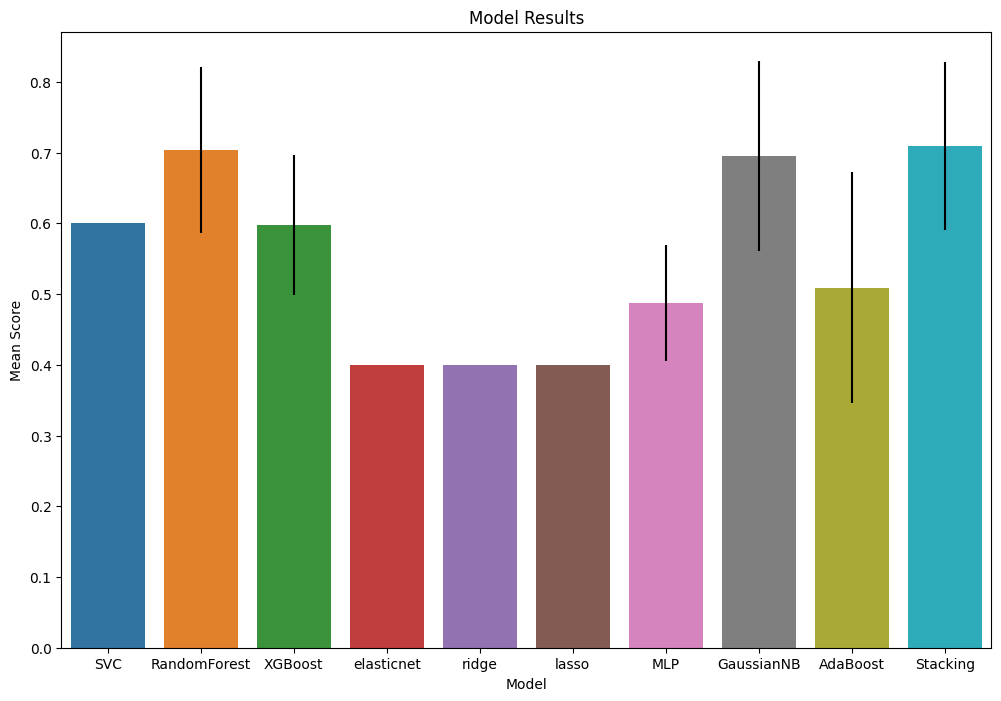

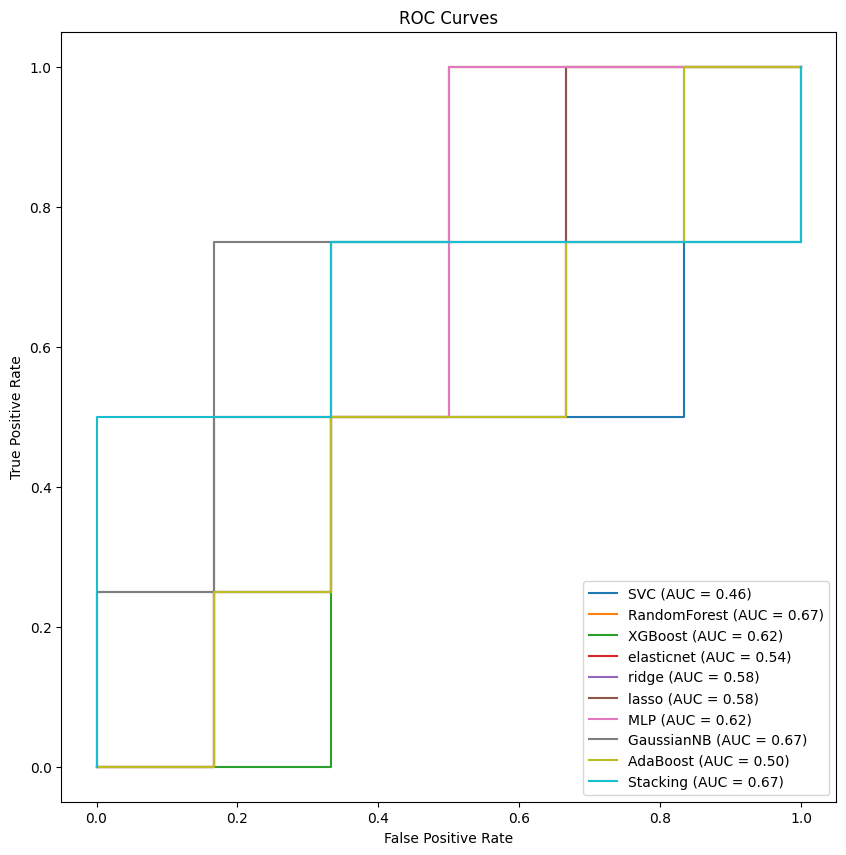

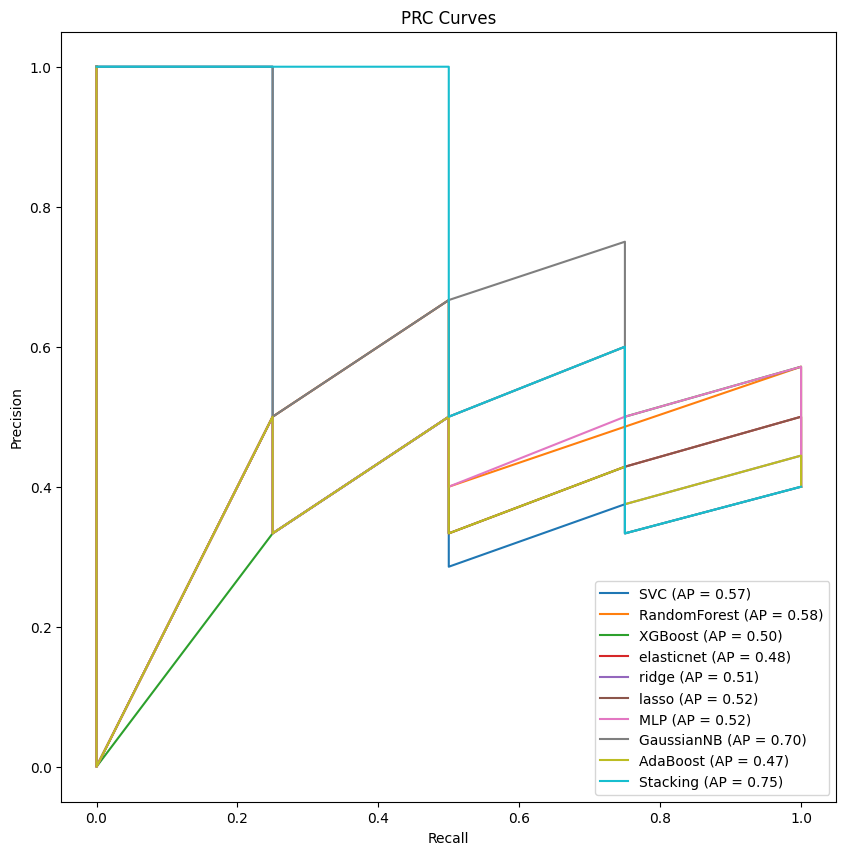

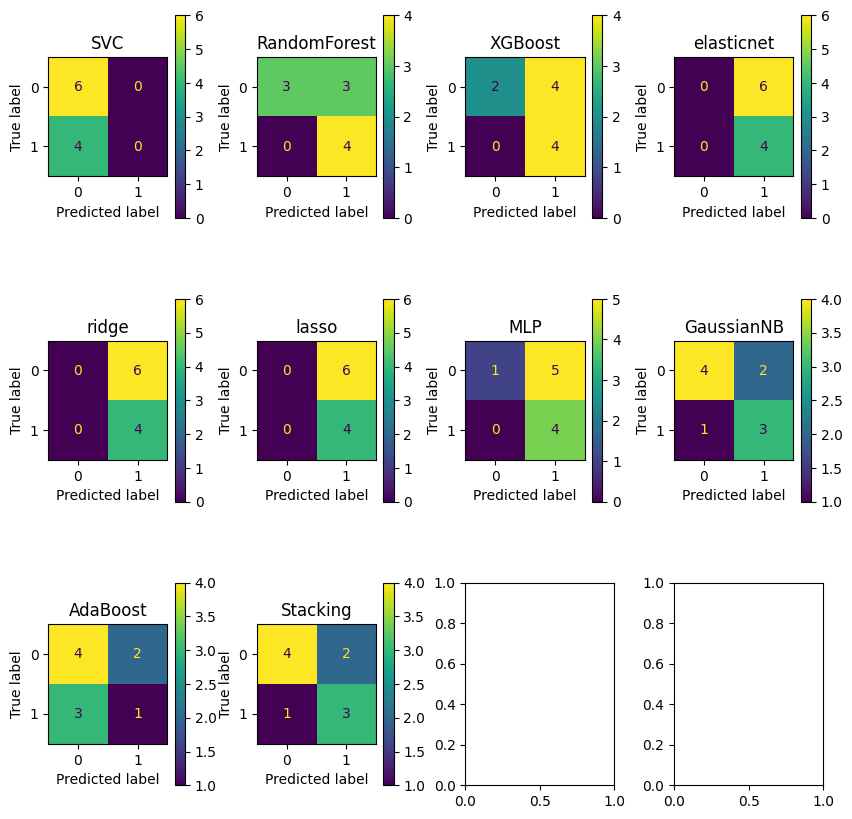

In [13]:
###### Load in HARP Data
harp_counts = pd.read_csv(path + 'harp_wb_hyperreactivity_data.csv', index_col=0).T
harp_counts[harp_counts == np.inf] = 0
harp_counts[harp_counts == -np.inf] = 0

harp_labels = pd.read_csv(path + 'harp_wb_hyperreactivity_labels.csv', index_col=0).to_numpy().ravel()

# Standardize data
harp_counts = scaler.transform(harp_counts)
harp_counts = rfecv.transform(harp_counts)

# Print out shapes
print("harp_counts shape: ", harp_counts.shape)
print("harp_labels shape: ", harp_labels.shape)


######################################################################
# Plot the testing results for each model
# Cross validate models
res = modeling.test_models(models, harp_counts, harp_labels)
# Plot results using plot_model_results function
plotting.plot_model_results(res)

# Plot the roc curves for each model
plotting.plot_roc_curves(models, harp_counts, harp_labels)

# Plot the prc curves for each model
plotting.plot_prc_curves(models, harp_counts, harp_labels)

# Plot the confusion matrices for each model
plotting.plot_confusion_matrices(models, harp_counts, harp_labels)

harp_counts shape:  (67, 37)
harp_labels shape:  (67,)


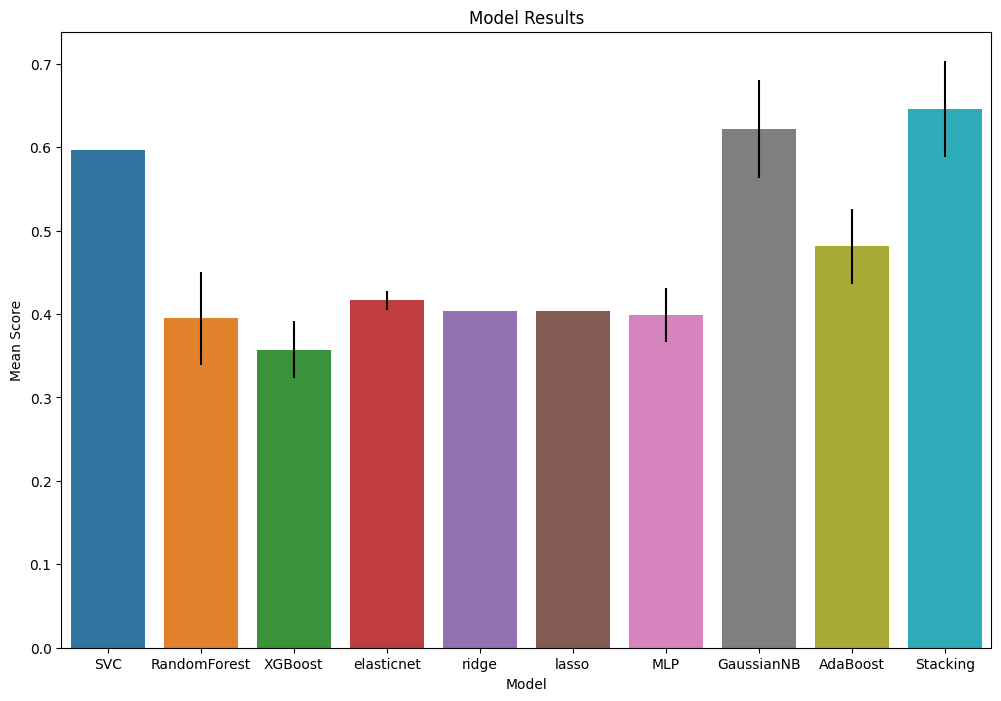

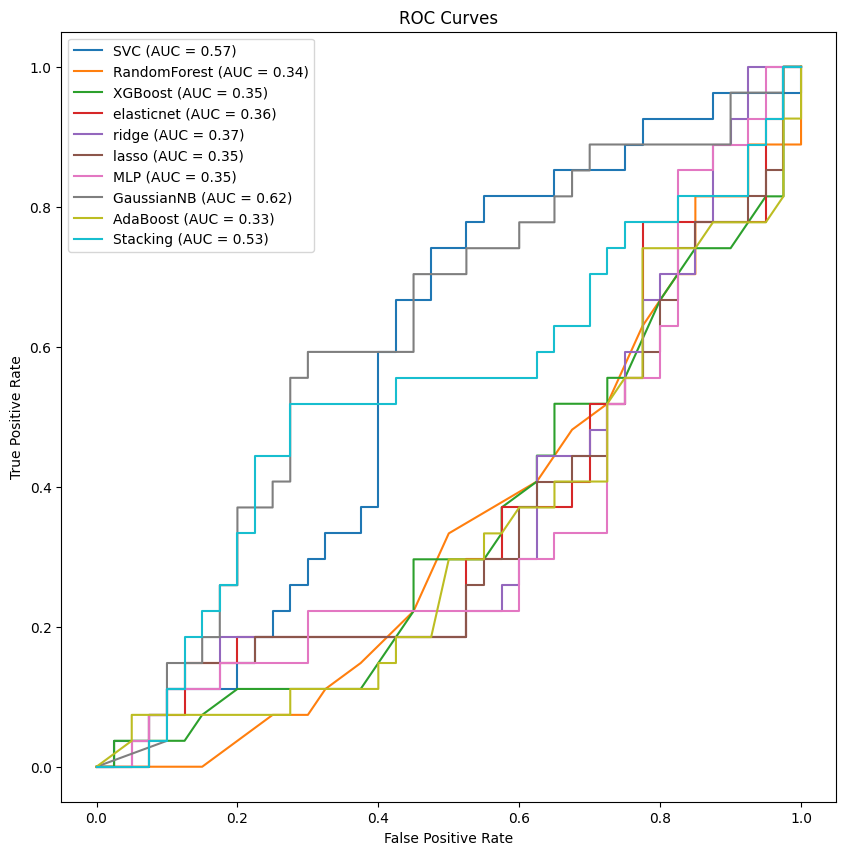

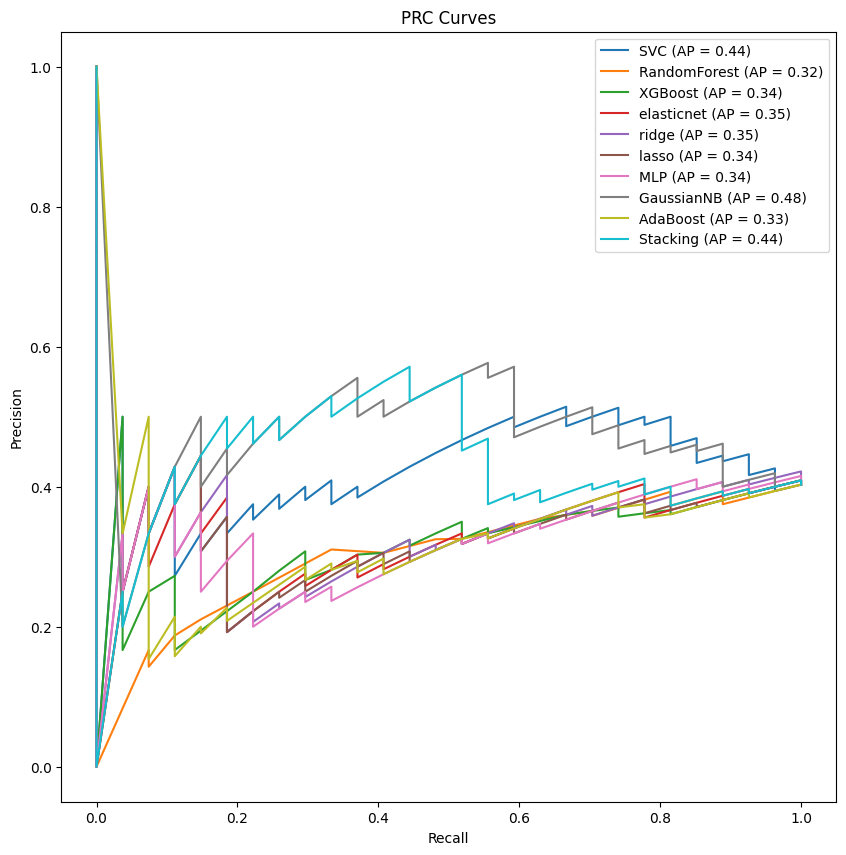

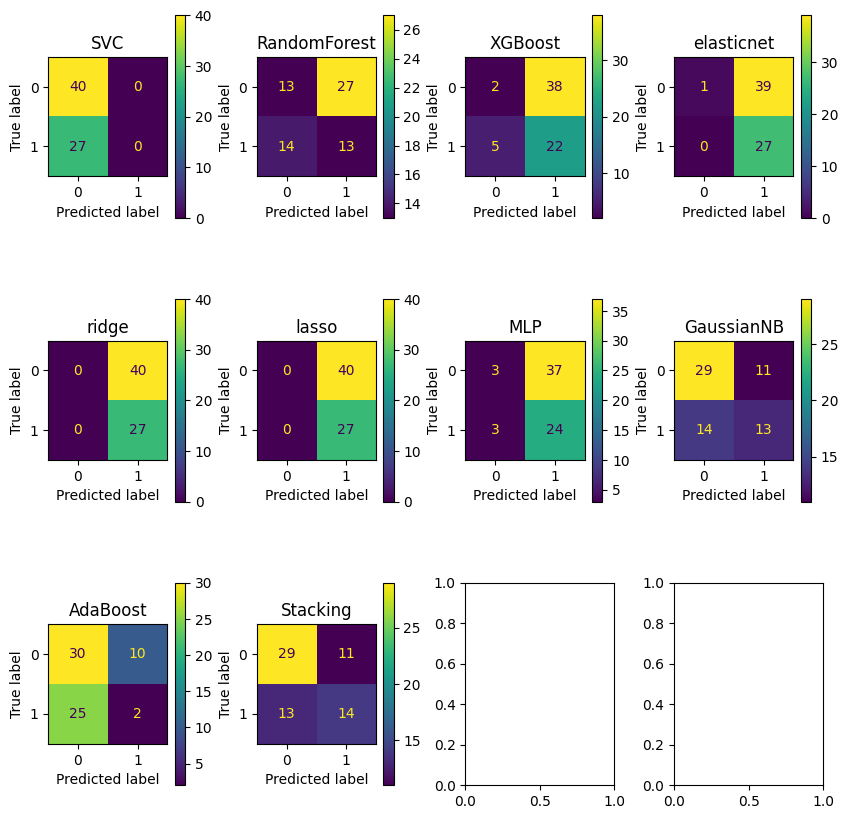

In [14]:
# HARP MI-CAD Prediction Enrichment

###### Load in HARP Data
harp_counts = pd.read_csv(path + 'harp_wb_micad_data.csv', index_col=0).T
harp_counts[harp_counts == np.inf] = 0
harp_counts[harp_counts == -np.inf] = 0

harp_labels = pd.read_csv(path + 'harp_wb_micad_labels.csv', index_col=0).to_numpy().ravel()

# Standardize data
harp_counts = scaler.transform(harp_counts)
harp_counts = rfecv.transform(harp_counts)

# Print out shapes
print("harp_counts shape: ", harp_counts.shape)
print("harp_labels shape: ", harp_labels.shape)


######################################################################
# Plot the testing results for each model
# Cross validate models
res = modeling.test_models(models, harp_counts, harp_labels)
# Plot results using plot_model_results function
plotting.plot_model_results(res)

# Plot the roc curves for each model
plotting.plot_roc_curves(models, harp_counts, harp_labels)

# Plot the prc curves for each model
plotting.plot_prc_curves(models, harp_counts, harp_labels)

# Plot the confusion matrices for each model
plotting.plot_confusion_matrices(models, harp_counts, harp_labels)

In [ ]:
# import pickle

# # save the models
# for model in models:
#     with open(outdir + model + '.pkl', 'wb') as f:
#         pickle.dump(models[model], f)

# # save the scaler
# with open(outdir + 'scaler.pkl', 'wb') as f:
#     pickle.dump(scaler, f)

# # save the rfecv
# with open(outdir + 'rfecv.pkl', 'wb') as f:
#     pickle.dump(rfecv, f)

# # save the optimal features as a csv
# pd.DataFrame(optimal_features).to_csv(outdir + 'optimal_features.csv', index=False)

In [15]:
# load optimal features
optimal_features = pd.read_csv(outdir + 'optimal_features.csv').to_numpy().ravel()

optimal_features

array(['ABCC6', 'ABO', 'AC009533.1', 'AC018644.1', 'AC023509.3',
       'AC025442.2', 'AC027020.2', 'AC027373.1', 'AC136475.2',
       'AL513329.1', 'AL604028.2', 'CCDC122', 'CDKN2A', 'CELA1', 'DBNDD2',
       'DSP', 'DZIP1L', 'EDN1', 'ESR1', 'F2RL1', 'FAM83F', 'FMN1',
       'FNDC3B', 'GPRC5C', 'GRM2', 'HTRA3', 'KCNK5', 'MYRF', 'NOMO3',
       'OLFM1', 'PI4KAP1', 'PIPSL', 'PLPP7', 'PRRT4', 'SORBS1', 'TMEM51',
       'WNT6'], dtype=object)

Training Data


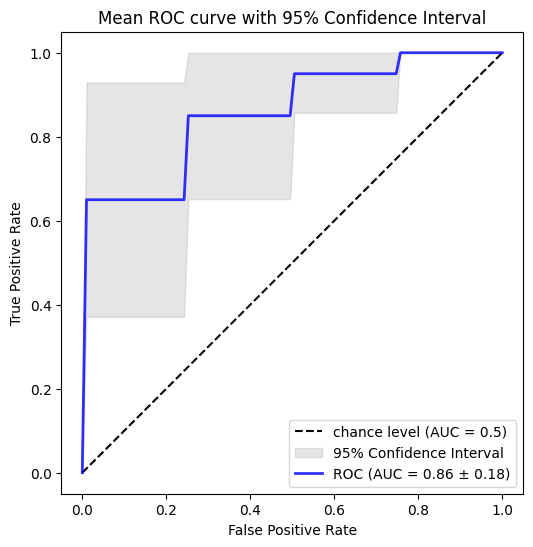

Testing Data


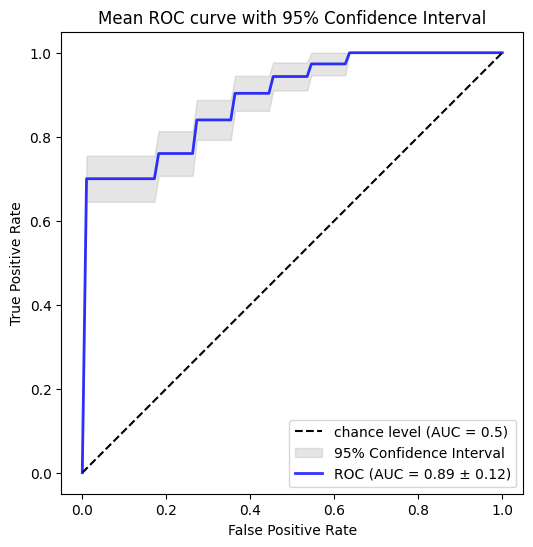

HARP Hyper Data


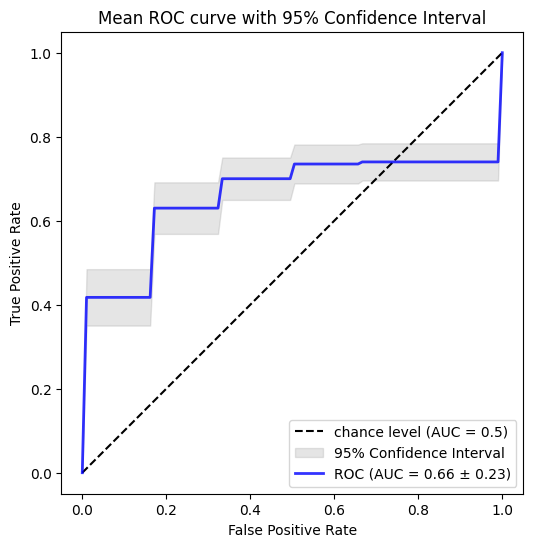

HARP MICAD Data


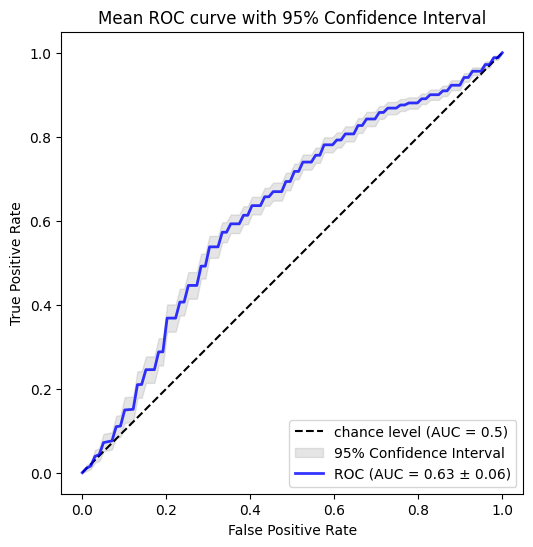

In [16]:
# Look at an individual model
model = 'GaussianNB'

from MattTools.stats import Bootstrap
# Plot the roc curve for the model training data
cv = StratifiedKFold(n_splits=10)
print("Training Data")
plotting.plot_training_roc_curve_ci(models[model], X_train, y_train, cv=cv)

# Plot the roc curve for the model testing data
bs = Bootstrap(n_bootstrap=100)
print("Testing Data")
plotting.plot_roc_curve_ci(models[model], X_test, y_test, cv=bs)


# Plot the roc curve for the model harp data
###### Load in HARP Data
harp_counts = pd.read_csv(path + 'harp_wb_hyperreactivity_data.csv', index_col=0).T
harp_labels = pd.read_csv(path + 'harp_wb_hyperreactivity_labels.csv', index_col=0).to_numpy().ravel()
# Standardize data
harp_counts = scaler.transform(harp_counts)
harp_counts = rfecv.transform(harp_counts)

bs = Bootstrap(n_bootstrap=100)
print("HARP Hyper Data")
plotting.plot_roc_curve_ci(models[model], harp_counts, harp_labels, cv=bs)


# Plot the roc curve for the model harp data
###### Load in HARP Data
harp_counts = pd.read_csv(path + 'harp_wb_micad_data.csv', index_col=0).T
harp_labels = pd.read_csv(path + 'harp_wb_micad_labels.csv', index_col=0).to_numpy().ravel()
# Standardize data
harp_counts = scaler.transform(harp_counts)
harp_counts = rfecv.transform(harp_counts)

bs = Bootstrap(n_bootstrap=100)
print("HARP MICAD Data")
plotting.plot_roc_curve_ci(models[model], harp_counts, harp_labels, cv=bs)